# A comparison of the effects of tesseroids against a spherical shell

This notebook compares the gravitational fields calculated for a tesseroid model against the analytical solution for a spherical shell.

The tesseroid fields are calculated using a range of distance/size ratios for the recursive division of the tesseroids. The sphell fields are used as a reference, or "ground truth". We use the difference between the tesseroid and reference fields to quantify the error in the tesseroid calculations for each distance/size ratio. 

## Provenance information

Load libraries and print the version information.

In [1]:
%matplotlib inline
from __future__ import division
import os
from timeit import timeit
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rc_file
rc_file('matplotlibrc')
from fatiando.mesher import Tesseroid, TesseroidMesh
from fatiando.constants import MEAN_EARTH_RADIUS, G, SI2EOTVOS, SI2MGAL
from fatiando import gridder
import fatiando

In [2]:
print('Fatiando a Terra version: {}\n'.format(fatiando.__version__))

Fatiando a Terra version: 0.3



In [3]:
!tessgz --version

1.2.0

## Make a directory for temporary computation files

In [4]:
filedir = 'tesseroid_vs_spherical_shell_files'
!mkdir -p $filedir

## Gravitational effect of a spherical shell

The analytical solution exists for an observation point located at a geocentric radial coordinate $r$. We can pretend that the point is at any latitude and longitude because of the symmetry of the shell.

The potential and its first and second derivatives are given by (Grombein et al., 2013):

$$
V(r) = \dfrac{4}{3}\pi G \rho \dfrac{r_2^3 - r_1^3}{r},
$$

$$
g_z(r) = \dfrac{V(r)}{r},
$$

$$
g_{zz}(r) = 2\dfrac{V(r)}{r^2},
$$

$$
g_{xx}(r) = g_{yy}(r) = -\dfrac{g_{zz}}{2} = -\dfrac{V(r)}{r^2},,
$$


and (because of the symmetry of the shell)

$$
g_x(r) = g_y(r) = g_{xy}(r) = g_{xz}(r) = g_{yz}(r) = 0,
$$


where $\rho$ is the dentity, $r$ is the radius coordinate of the observation point, $r_1$ and $r_2$ are radial coordinates of the bottom and top of the spherical shell, respectively.

The function below calculates the shell fields and returns them in a `pandas.Series`.

In [5]:
def calc_shell_effect(height, top, bottom, density):
    r = height + MEAN_EARTH_RADIUS
    # top and bottom are heights
    r1 = bottom + MEAN_EARTH_RADIUS
    r2 = top + MEAN_EARTH_RADIUS
    potential = (4/3)*np.pi*G*density*(r2**3 - r1**3)/r
    data = pd.Series({'pot': potential,
                      'gx': 0,
                      'gy': 0,
                      'gz': SI2MGAL*(potential/r),
                      'gxx': SI2EOTVOS*(-potential/r**2),
                      'gxy': 0,
                      'gxz': 0,
                      'gyy': SI2EOTVOS*(-potential/r**2),
                      'gyz': 0,
                      'gzz': SI2EOTVOS*(2*potential/r**2)})
    return data

## Tesseroid model of the spherical shell

I'll use the `TesseroidMesh` of Fatiando a Terra to make a model of a spherical shell. The model needs to be written to a file so that I can use the [Tesseroids](http://www.leouieda.com/tesseroids) command-line programs on it.

The function below takes the size (in degrees), top, bottom and density, makes the tesseroids and saves them to a file.

In [6]:
def make_model_file(size, top, bottom, density, verbose=False, return_mesh=False):
    bounds = [0, 360, -90, 90, top, bottom]
    nlon = int(360/size)
    assert nlon - 360/size == 0
    nlat = int(180/size)
    assert nlat - 180/size == 0
    mesh = TesseroidMesh(bounds, (1, nlat, nlon))
    # the 3rd dim is - because of a quirk in TesseroidMesh
    assert mesh.dims == (size, size, -(top - bottom))
    assert mesh.size == nlat*nlon
    fname = os.path.join(filedir, 'model-size{:.1f}.tess'.format(size))
    with open(fname, 'w') as f:
        for t in mesh:
            f.write('{} {} {} {} {} {} {}\n'.format(
                t.w, t.e, t.s, t.n, t.top, t.bottom, density))
    tmp = !cat $fname | grep -v "#" | grep -e "^$" -v| wc -l
    tess_in_file = int(tmp[0])
    assert mesh.size == tess_in_file
    if verbose:
        print('Model file: {}'.format(fname))
        print('Model size: {}'.format(tess_in_file))
        print('Head:')
        !head $fname
        print('Tail:')
        !tail $fname
    if return_mesh:
        return fname, mesh
    else:
        return fname

We'll make a 1 x 1 degree tesseroid model first. Later on, we'll run the computations for other sizes to see if the results are size dependent.

In [7]:
size = 1
top, bottom = 1000, 0
density = 2670

In [8]:
model_file = make_model_file(size, top, bottom, density, verbose=True)

Model file: tesseroid_vs_spherical_shell_files/model-size1.0.tess
Model size: 64800
Head:
0.0 1.0 -90.0 -89.0 1000.0 0.0 2670
1.0 2.0 -90.0 -89.0 1000.0 0.0 2670
2.0 3.0 -90.0 -89.0 1000.0 0.0 2670
3.0 4.0 -90.0 -89.0 1000.0 0.0 2670
4.0 5.0 -90.0 -89.0 1000.0 0.0 2670
5.0 6.0 -90.0 -89.0 1000.0 0.0 2670
6.0 7.0 -90.0 -89.0 1000.0 0.0 2670
7.0 8.0 -90.0 -89.0 1000.0 0.0 2670
8.0 9.0 -90.0 -89.0 1000.0 0.0 2670
9.0 10.0 -90.0 -89.0 1000.0 0.0 2670
Tail:
350.0 351.0 89.0 90.0 1000.0 0.0 2670
351.0 352.0 89.0 90.0 1000.0 0.0 2670
352.0 353.0 89.0 90.0 1000.0 0.0 2670
353.0 354.0 89.0 90.0 1000.0 0.0 2670
354.0 355.0 89.0 90.0 1000.0 0.0 2670
355.0 356.0 89.0 90.0 1000.0 0.0 2670
356.0 357.0 89.0 90.0 1000.0 0.0 2670
357.0 358.0 89.0 90.0 1000.0 0.0 2670
358.0 359.0 89.0 90.0 1000.0 0.0 2670
359.0 360.0 89.0 90.0 1000.0 0.0 2670


## Tesseroid gravitational effect at 2 km height (1 km above the shell)

Now we need to calculate the gravitational effect of this tesseroid model using a range of distance/size ratios. The function below takes a model file name,  height of observations, tesseroid size, and a distance to size ratio. It makes a computation grid at the given height. The grid is placed over the North pole from 90º latitude until 90º - the size of the tesseroids. This way, he grid covers all the tesseroids that are around the pole.

In [9]:
def calc_tess_effect(fname, height, size, ratio, where='pole'):
    if ratio == 0:
        flag = '-a'
    else:
        flag = '-t{:f}'.format(ratio)
    # Make a computation grid above a tesseroid
    if where == 'pole':
        lats, lons = gridder.regular([90 - size, 90, 0, size], (10, 10))
    elif where == 'equator':
        lats, lons = gridder.regular([0, size, 0, size], (10, 10))
    else:
        raise ValueError("Invalid argument where='{}'".format(where))
    tmp = 'effect-{}-ratio{:.1f}-height{:.0f}-{}.txt'.format(os.path.split(fname)[1], ratio, height, where)
    outfile = os.path.join(filedir, tmp)
    grid_text = '\n'.join('{:f} {:f} {:f}'.format(lon, lat, height) 
                          for lon, lat in zip(lons, lats))
    !echo "$grid_text" | \
        tesspot $fname $flag | \
        tessgx $fname $flag | \
        tessgy $fname $flag | \
        tessgz $fname $flag | \
        tessgxx $fname $flag | \
        tessgxy $fname $flag | \
        tessgxz $fname $flag | \
        tessgyy $fname $flag | \
        tessgyz $fname $flag | \
        tessgzz $fname $flag > $outfile
    return outfile

Now we can specify a range of distance/size ratios and a computation height...

In [10]:
ratio = np.arange(0, 10.5, 0.5)
height = top + 1000

... and calculate the effect of the tesseroid model for each ratio.

In [11]:
tess_out_files = []
for r in ratio:
    f = calc_tess_effect(model_file, height, size, r)
    print('Done: {}'.format(f))
    tess_out_files.append(f)

Done: tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio0.0-height2000-pole.txt
Done: tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio0.5-height2000-pole.txt
Done: tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio1.0-height2000-pole.txt
Done: tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio1.5-height2000-pole.txt
Done: tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio2.0-height2000-pole.txt
Done: tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio2.5-height2000-pole.txt
Done: tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio3.0-height2000-pole.txt
Done: tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio3.5-height2000-pole.txt
Done: tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio4.0-height2000-pole.txt
Done: tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio4.5-height2000-pole.txt
Done: tesseroid_vs_spherical_shell_files

## Comparison of spherical shell effect and tesseroid model

Now I can load the calculated fields of the tesseroid model and compare it with the calculated effect for the real spherical shell.

In [12]:
shell_data = calc_shell_effect(height, top, bottom, density)
shell_data

gx         0.000000
gxx       -0.350758
gxy        0.000000
gxz        0.000000
gy         0.000000
gyy       -0.350758
gyz        0.000000
gz       223.788630
gzz        0.701517
pot    14278.021191
dtype: float64

and save the results to a CSV (Comma Sparated Values) file.

In [13]:
shell_data.to_csv('../data/shell-height-{:.0f}.csv'.format(height))

I'll load the tesseroid data into a `pandas.DataFrame` object. This is a like a spreadsheet, but better. The columns are the fields (gx, gy, etc), file name, ratio used, and tesseroid size.

In [14]:
def load_tess_data(files, ratio, size):
    df = pd.DataFrame(columns=['file', 'ratio', 'size', 'gx', 'gxx', 'gxy', 'gxz', 'gy', 
                               'gyy', 'gyz', 'gz', 'gzz', 'pot'])
    for r, fname in zip(ratio, files):
        data = np.loadtxt(fname, unpack=True)[3:]
        tmp = pd.DataFrame({'file': fname,
                            'ratio': r,
                            'size': size,
                            'pot': data[0],
                            'gx': data[1],
                            'gy': data[2],
                            'gz': data[3],
                            'gxx': data[4],
                            'gxy': data[5],
                            'gxz': data[6],
                            'gyy': data[7],
                            'gyz': data[8],
                            'gzz': data[9]})
        df = df.append(tmp, ignore_index=True)
    df.index.name = 'point'
    return df            

Lets take a look at the tesseroid data:

In [15]:
tess_data = load_tess_data(tess_out_files, ratio, size)
tess_data.head()

,file,gx,gxx,gxy,gxz,gy,gyy,gyz,gz,gzz,pot,ratio,size
point,,,,,,,,,,,,,
0,tesseroid_vs_spherical_shell_files/effect-mode...,-3.582888,81.667048,2.864375e-14,0.562671,3.860939e-13,0.126986,-3.513682e-15,124.244845,-81.794034,14271.388132,0,1
1,tesseroid_vs_spherical_shell_files/effect-mode...,133.400119,184.671435,-6.306067e-14,-38.871249,-4.396483e-14,-13.693074,7.327472e-15,138.387916,-170.978361,14278.240812,0,1
2,tesseroid_vs_spherical_shell_files/effect-mode...,-653.651914,-820.755567,-3.728928e-11,5361.923206,2.995648e-11,37.295314,-5.456968e-11,910.070144,783.460224,14311.554203,0,1
3,tesseroid_vs_spherical_shell_files/effect-mode...,-133.389015,115.108381,4.096723e-14,24.315601,-3.491651e-14,17.760055,6.925016e-15,132.259807,-132.868436,14273.562885,0,1
4,tesseroid_vs_spherical_shell_files/effect-mode...,-45.355184,49.847512,7.965850e-15,3.123839,-3.358425e-15,7.142522,6.210310e-16,120.411687,-56.990034,14263.270443,0,1


I'll save this to a CSV file as well for later use. It's easier to load that way than parsing all the output files again.

In [16]:
tess_data.to_csv('../data/tesseroid-size-{:.0f}-height-{:.0f}-pole.csv'.format(size, height))

Now I can use some pandas magic to calculate the difference between the shell effect and the tesseroid effect. This will also be stored in a `DataFrame`. The values are the absolute value of the differences for each size and ratio.

In [17]:
def calc_difference(tess_data, shell_data):
    # Subtract the field columns and take the absolute value
    diff = tess_data.drop(['file', 'size', 'ratio'], axis='columns').sub(shell_data, axis='columns').abs()
    # Then, add the size and ratio columns to the difference
    diff[['size', 'ratio']] = tess_data[['size', 'ratio']]
    return diff

In [18]:
diff = calc_difference(tess_data, shell_data)
diff.head()

,gx,gxx,gxy,gxz,gy,gyy,gyz,gz,gzz,pot,size,ratio
point,,,,,,,,,,,,
0,3.582888,82.017807,2.864375e-14,0.562671,3.860939e-13,0.477744,3.513682e-15,99.543785,82.495551,6.633058,1,0
1,133.400119,185.022193,6.306067e-14,38.871249,4.396483e-14,13.342316,7.327472e-15,85.400714,171.679878,0.219622,1,0
2,653.651914,820.404809,3.728928e-11,5361.923206,2.995648e-11,37.646072,5.456968e-11,686.281514,782.758707,33.533012,1,0
3,133.389015,115.459139,4.096723e-14,24.315601,3.491651e-14,18.110814,6.925016e-15,91.528824,133.569953,4.458306,1,0
4,45.355184,50.198270,7.965850e-15,3.123839,3.358425e-15,7.493281,6.210310e-16,103.376943,57.691551,14.750748,1,0


I'll save the differences as well to avoid recomputing.

In [19]:
diff.to_csv('../data/difference-size-{:.0f}-height-{:.0f}-pole.csv'.format(size, height))

To get the maximum difference per size per ratio, I can use the `DataFrame.groupby` method.

In [20]:
max_diff = diff.groupby(['size', 'ratio']).max()
max_diff

gx         gxx        gxy          gxz        gy  \
size ratio                                                             
1    0.0    769.086112  854.704698  26.822236  5372.013197  0.876313   
     0.5     11.215857   85.182630  21.765414    45.271905  1.271564   
     1.0      0.463330   19.514930   2.203664    13.430373  0.236333   
     1.5      0.070450    1.144707   0.209287     0.557937  0.031353   
     2.0      0.022737    0.149761   0.024231     0.120548  0.005499   
     2.5      0.008500    0.051286   0.008734     0.026611  0.002261   
     3.0      0.003946    0.015951   0.005038     0.008864  0.000848   
     3.5      0.001777    0.009913   0.001601     0.005218  0.000305   
     4.0      0.001194    0.007222   0.000898     0.002226  0.000269   
     4.5      0.000614    0.003432   0.000450     0.000784  0.000065   
     5.0      0.000410    0.002540   0.000442     0.001013  0.000058   
     5.5      0.000240    0.001280   0.000147     0.000491  0.000030   
     6.0      0.000179    0.000925   0.000084     0.000573  0.000020   
     6.5      0.000131    0.000641   0.000085     0.000260  0.000015   
     7.0      0.000095    0.000510   0.000048     0.000242  0.000014   
     7.5      0.000084    0.000569   0.000038     0.000169  0.000010   
     8.0      0.000055    0.000345   0.000024     0.000110  0.000009   
     8.5      0.000044    0.000249   0.000015     0.000087  0.000005   
     9.0      0.000037    0.000216   0.000009     0.000075  0.000004   
     9.5      0.000032    0.000178   0.000007     0.000054  0.000004   
     10.0     0.000023    0.000117   0.000007     0.000047  0.000002   

                   gyy        gyz          gz         gzz        pot  
size ratio                                                            
1    0.0    311.835644  27.800405  686.281514  782.758707  33.533012  
     0.5     64.388814  13.539341   99.543785  128.777627   6.633058  
     1.0     12.838965   8.384167    1.027770   32.012723   0.074944  
     1.5      1.392990   0.662468    0.203132    2.289414   0.023323  
     2.0      0.208828   0.123601    0.020666    0.283195   0.007042  
     2.5      0.104713   0.027675    0.015305    0.117553   0.002195  
     3.0      0.029259   0.008855    0.004941    0.026251   0.001310  
     3.5      0.021229   0.004236    0.004276    0.026761   0.000574  
     4.0      0.007639   0.002814    0.001837    0.014445   0.000486  
     4.5      0.005101   0.001056    0.001475    0.006772   0.000206  
     5.0      0.003265   0.001003    0.000840    0.004182   0.000201  
     5.5      0.002198   0.000500    0.000687    0.003024   0.000089  
     6.0      0.001108   0.000233    0.000459    0.001780   0.000092  
     6.5      0.001000   0.000185    0.000379    0.001285   0.000050  
     7.0      0.000499   0.000156    0.000266    0.000998   0.000046  
     7.5      0.000569   0.000083    0.000219    0.001138   0.000030  
     8.0      0.000345   0.000055    0.000150    0.000690   0.000027  
     8.5      0.000249   0.000053    0.000123    0.000498   0.000018  
     9.0      0.000179   0.000044    0.000095    0.000272   0.000019  
     9.5      0.000144   0.000023    0.000079    0.000258   0.000012  
     10.0     0.000115   0.000020    0.000065    0.000181   0.000012

I'll plot the maximum difference as a function of distance/size ratio. I'll also plot the relative difference (difference divided by the shell value) in percentage.

In [21]:
def plot_difference(diff, shell_data, size=size):
    fig, subplots = plt.subplots(5, 2, figsize=(10, 10))
    for f, axes in zip(['pot', 'gz', 'gxx', 'gyy', 'gzz'], subplots):
        maxd = diff[f].loc[size, :]
        ax1, ax2 = axes
        ax1.text(0.8, 0.8, f, fontsize=16, transform=ax1.transAxes)
        ax1.plot(ratio, maxd, '.-')
        ax1.set_yscale('log')
        ax1.grid(True)
        ax1.set_ylabel('Difference')
        ax2.plot(ratio, 100*maxd/np.abs(shell_data[f]), '.-')
        ax2.set_yscale('log')
        ax2.grid(True)
        ax2.set_ylabel('Difference (\%)')
        ax2.hlines(0.1, ratio.min(), ratio.max(), colors='r')
        ax2.set_xlim(ratio.min(), ratio.max())
        ax1.set_xticks(range(10))
        ax2.set_xticks(range(10))
    ax1.set_xlabel('Distance/size ratio')
    ax2.set_xlabel('Distance/size ratio')
    ax1, ax2 = subplots[0]
    ax1.set_title('Absolute difference')
    ax2.set_title('Relative difference')
    plt.tight_layout()
    return fig

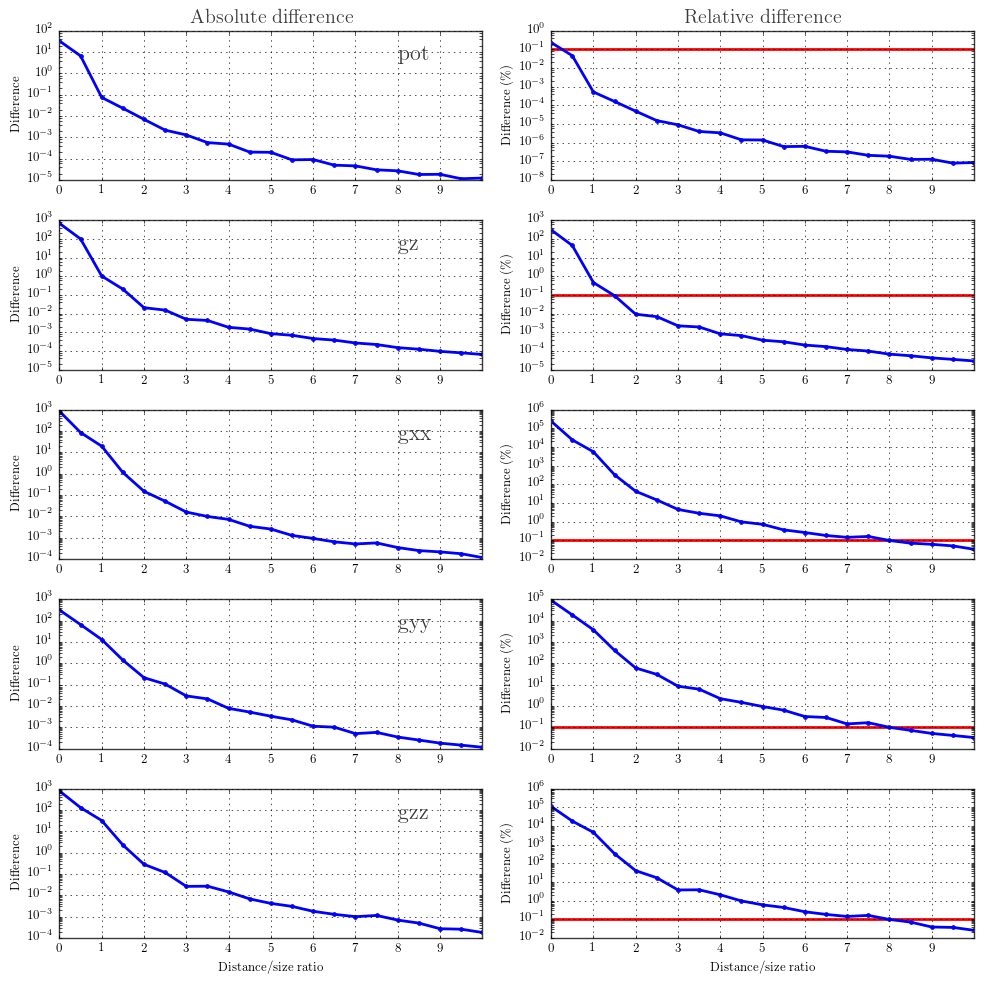

In [22]:
plot_difference(max_diff, shell_data)

## Verify the comparison at 260 km height

Run the comparison again to see how big the errors are per ratio and if they are below the threshold when computing at 260 km height (GOCE orbit height).

In [23]:
goce_height = 260e3
goce_height_out_files = []
for r in ratio:
    f = calc_tess_effect(model_file, goce_height, size, r, where='pole')
    print('Done: {}'.format(f))
    goce_height_out_files.append(f)

Done: tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio0.0-height260000-pole.txt
Done: tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio0.5-height260000-pole.txt
Done: tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio1.0-height260000-pole.txt
Done: tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio1.5-height260000-pole.txt
Done: tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio2.0-height260000-pole.txt
Done: tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio2.5-height260000-pole.txt
Done: tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio3.0-height260000-pole.txt
Done: tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio3.5-height260000-pole.txt
Done: tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio4.0-height260000-pole.txt
Done: tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio4.5-height260000-pole.txt
Done: tesseroid_vs_s

Load the data from the output files and save it to a CSV.

In [24]:
goce_height_data = load_tess_data(goce_height_out_files, ratio, size)

In [25]:
goce_height_data.to_csv('../data/tesseroid-size-{:.0f}-height-{:.0f}-pole.csv'.format(size, goce_height))

Calculate the shell fields at the new height as well.

In [26]:
goce_height_shell_data = calc_shell_effect(goce_height, top, bottom, density)
goce_height_shell_data

gx         0.000000
gxx       -0.311429
gxy        0.000000
gxz        0.000000
gy         0.000000
gyy       -0.311429
gyz        0.000000
gz       206.730999
gzz        0.622858
pot    13723.086957
dtype: float64

In [27]:
goce_height_shell_data.to_csv('../data/shell-height-{:.0f}.csv'.format(goce_height))

Calculate and save the differences.

In [28]:
goce_height_diff = calc_difference(goce_height_data, goce_height_shell_data)

In [29]:
goce_height_diff.to_csv('../data/difference-size-{:.0f}-height-{:.0f}-pole.csv'.format(size, goce_height))

Plot the maximum difference per ratio.

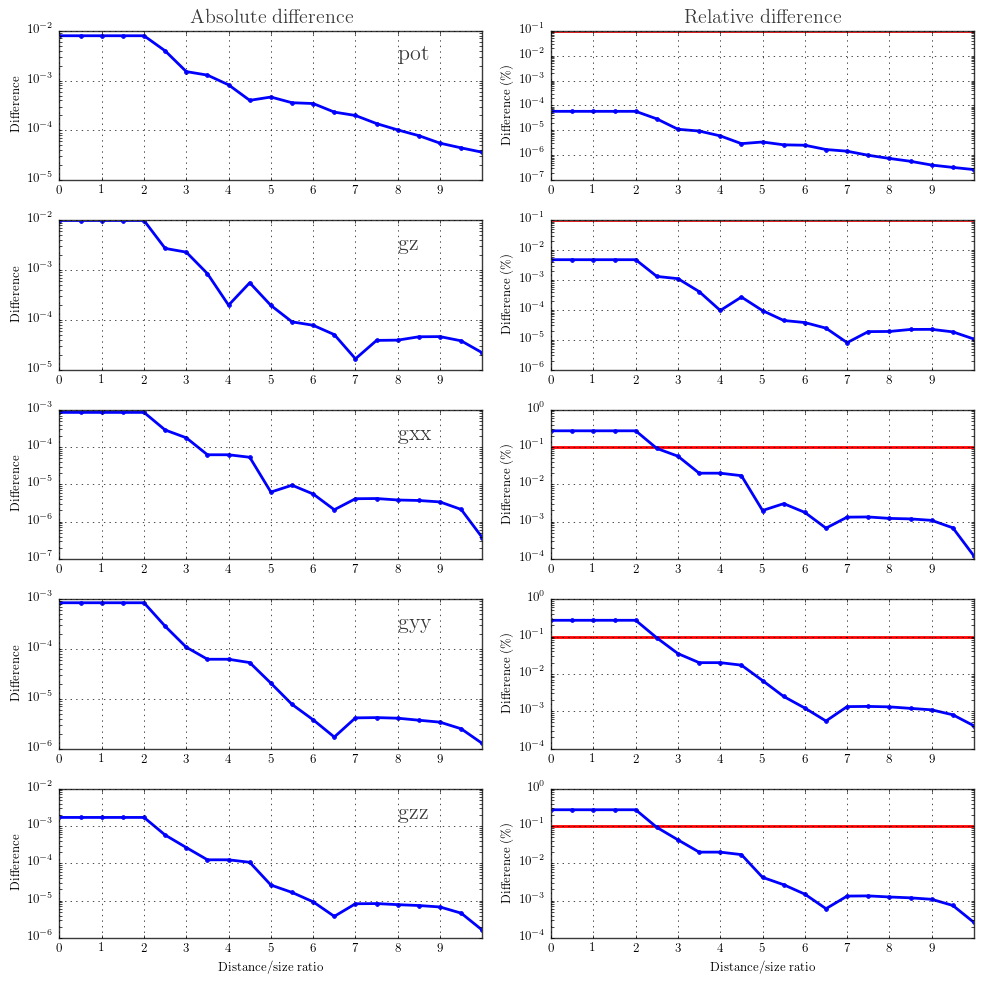

In [30]:
goce_height_max_diff = goce_height_diff.groupby(['size', 'ratio']).max()
plot_difference(goce_height_max_diff, goce_height_shell_data)

## Very the comparison at the equator

Lets verify that the results are also valid at the equator, where tesseroids have a very different shape.

In [31]:
equator_out_files = []
for r in ratio:
    f = calc_tess_effect(model_file, height, size, r, where='equator')
    print('  {}'.format(f))
    equator_out_files.append(f)

  tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio0.0-height2000-equator.txt
  tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio0.5-height2000-equator.txt
  tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio1.0-height2000-equator.txt
  tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio1.5-height2000-equator.txt
  tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio2.0-height2000-equator.txt
  tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio2.5-height2000-equator.txt
  tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio3.0-height2000-equator.txt
  tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio3.5-height2000-equator.txt
  tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio4.0-height2000-equator.txt
  tesseroid_vs_spherical_shell_files/effect-model-size1.0.tess-ratio4.5-height2000-equator.txt
  tesseroid_vs_spherical_shell_files/effect-model-

In [32]:
eq_data = load_tess_data(equator_out_files, ratio, size)

In [33]:
eq_data.to_csv('../data/tesseroid-size-{:.0f}-height-{:.0f}-equator.csv'.format(size, height))

In [34]:
eq_diff = calc_difference(eq_data, shell_data)

In [35]:
eq_diff.to_csv('../data/difference-size-{:.0f}-height-{:.0f}-equator.csv'.format(size, height))

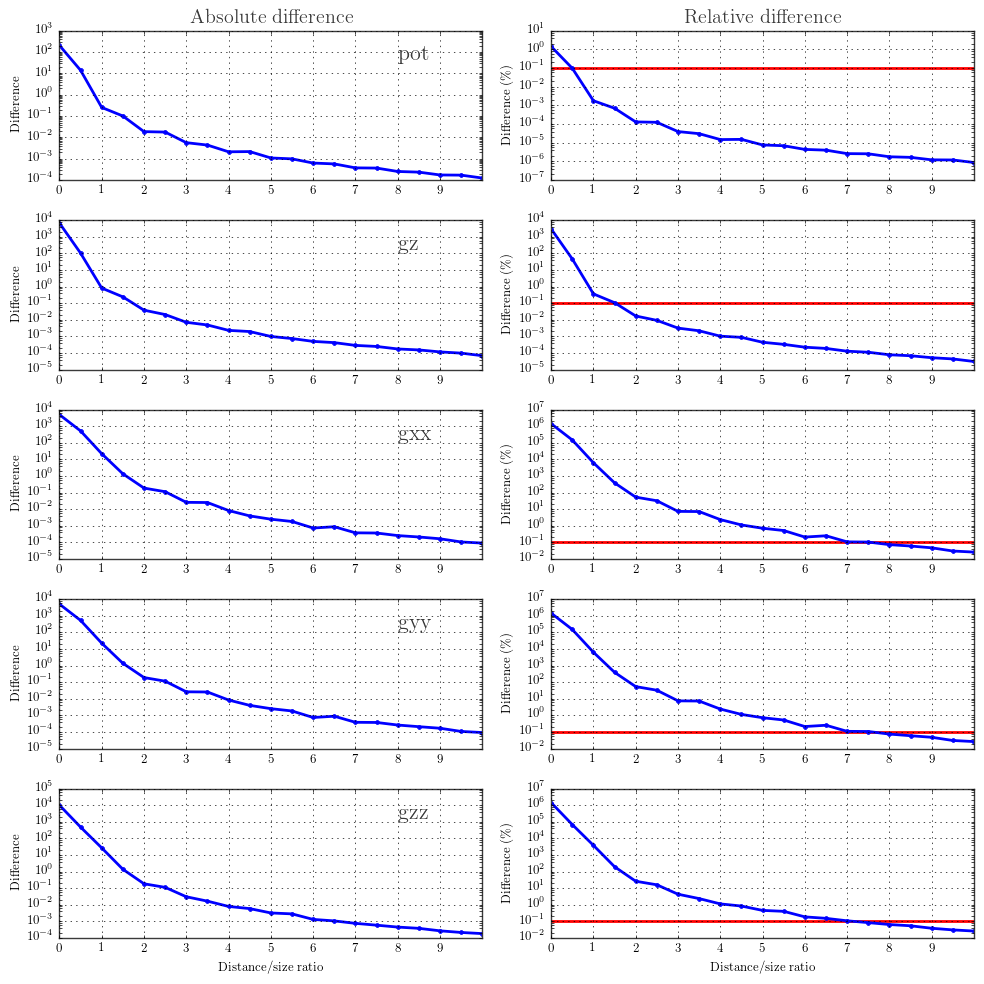

In [36]:
eq_max_diff = eq_diff.groupby(['size', 'ratio']).max()
plot_difference(eq_max_diff, shell_data)

## Check how gzz varies with computation height

I want to see how the difference x ratio curve varies with the computation height. We know 2 extremes (2 km and 260 km), but how fast does it decay?

First, we can get the data that we need from the 2 km and 260 km DataFrames.

In [37]:
tess_gzz_per_height = tess_data['file ratio size gzz'.split()]
tess_gzz_per_height['height'] = height
tmp = goce_height_data['file ratio size gzz'.split()]
tmp['height'] = goce_height
tess_gzz_per_height = tess_gzz_per_height.append(tmp, ignore_index=True)

/home/leo/bin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/home/leo/bin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Then, set the new heights to compute and make a function to run Tesseroids (only `tessgzz`) at each height (for a grid near the pole).

In [38]:
heights = [height, 10e3, 50e3, 150e3, goce_height]

In [39]:
def calc_tess_gzz(fname, height, size, ratio):
    if ratio == 0:
        flag = '-a'
    else:
        flag = '-t{:f}'.format(ratio)
    # Make a computation grid above a tesseroid
    lats, lons = gridder.regular([90 - size, 90, 0, size], (10, 10))
    tmp = 'gzz-{}-ratio{:.1f}-height{:.0f}.txt'.format(os.path.split(fname)[1], ratio, height)
    outfile = os.path.join(filedir, tmp)
    grid_text = '\n'.join('{:f} {:f} {:f}'.format(lon, lat, height) 
                          for lon, lat in zip(lons, lats))
    !echo "$grid_text" | tessgzz $fname $flag > $outfile
    return outfile

We'll need the shell effect at each different height as well.  We'll calculate the effects and group them in a `pandas.DataFrame` as well.

In [40]:
def shell_effect_with_height(height):
    "Helper function to append the height to the pandas.Series with the shell data"
    series = calc_shell_effect(height, top, bottom, density)
    series['height'] = height
    return series

shell_per_height = pd.DataFrame([shell_effect_with_height(h) for h in heights])
shell_per_height

,gx,gxx,gxy,gxz,gy,gyy,gyz,gz,gzz,pot,height
0,0,-0.350758,0,0,0,-0.350758,0,223.788630,0.701517,14278.021191,2000
1,0,-0.349442,0,0,0,-0.349442,0,223.228471,0.698884,14260.140521,10000
2,0,-0.342959,0,0,0,-0.342959,0,220.458972,0.685919,14171.404761,50000
3,0,-0.327439,0,0,0,-0.327439,0,213.756587,0.654878,13954.322847,150000
4,0,-0.311429,0,0,0,-0.311429,0,206.730999,0.622858,13723.086957,260000


In [41]:
shell_per_height.to_csv('../data/shell-per-height.csv')

Now we can calculate gzz for each height, load the data into a DataFrame and append it to our dataset.

In [42]:
for h in heights[1:-1]:
    files = [calc_tess_gzz(model_file, h, size, r) for r in ratio]
    # Load the data files into a DataFrame 
    tmp = pd.DataFrame(columns=['file', 'ratio', 'gzz'])
    for r, fname in zip(ratio, files):
        data = np.loadtxt(fname, usecols=[-1], unpack=True)
        tmp = tmp.append(pd.DataFrame(dict(file=fname, ratio=r, gzz=data)), 
                         ignore_index=True)
    tmp.index.name = 'point'
    tmp['height'] = h
    tmp['size'] = size
    tess_gzz_per_height = tess_gzz_per_height.append(tmp, ignore_index=True)
    print('Done: height {}'.format(h))

Done: height 10000.0
Done: height 50000.0
Done: height 150000.0


In [43]:
tess_gzz_per_height.head()

,file,gzz,height,ratio,size
0,tesseroid_vs_spherical_shell_files/effect-mode...,-81.794034,2000,0,1
1,tesseroid_vs_spherical_shell_files/effect-mode...,-170.978361,2000,0,1
2,tesseroid_vs_spherical_shell_files/effect-mode...,783.460224,2000,0,1
3,tesseroid_vs_spherical_shell_files/effect-mode...,-132.868436,2000,0,1
4,tesseroid_vs_spherical_shell_files/effect-mode...,-56.990034,2000,0,1


Again, save this to a CSV for later use.

In [44]:
tess_gzz_per_height.to_csv('../data/tesseroid-gzz-per-height-size-{:.0f}.csv'.format(size))

Calculate the difference for each height. Again, we'll load the differences for 2km and 260km from the previous results first.

In [45]:
diff_per_height = diff['ratio gzz'.split()]
diff_per_height['height'] = height
tmp = goce_height_diff['ratio gzz'.split()]
tmp['height'] = goce_height
diff_per_height = diff_per_height.append(tmp, ignore_index=True)

/home/leo/bin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/home/leo/bin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [46]:
for h in heights[1:-1]:    
    tmp = tess_gzz_per_height[tess_gzz_per_height['height'] == h]
    tmp_shell = shell_per_height[shell_per_height['height'] == h]['gzz']
    tmp_diff = pd.DataFrame(dict(gzz=(tmp['gzz'] - tmp_shell.values).abs()))
    tmp_diff[['ratio',  'height']] = tmp[['ratio', 'height']]
    diff_per_height = diff_per_height.append(tmp_diff, ignore_index=True)

In [47]:
diff_per_height.head()

,gzz,height,ratio
0,82.495551,2000,0
1,171.679878,2000,0
2,782.758707,2000,0
3,133.569953,2000,0
4,57.691551,2000,0


In [48]:
diff_per_height.to_csv('../data/difference-gzz-per-height-size-{:.0f}-pole.csv'.format(size))

Now I can calculate the maximum difference per ratio and plot a error-ratio curve per computation height.

In [49]:
max_diff_per_height = diff_per_height.groupby(['height', 'ratio']).max()

/home/leo/bin/anaconda/lib/python2.7/site-packages/pandas/core/index.py:648: FutureWarning: scalar indexers for index type MultiIndex should be integers and not floating point
  type(self).__name__),FutureWarning)


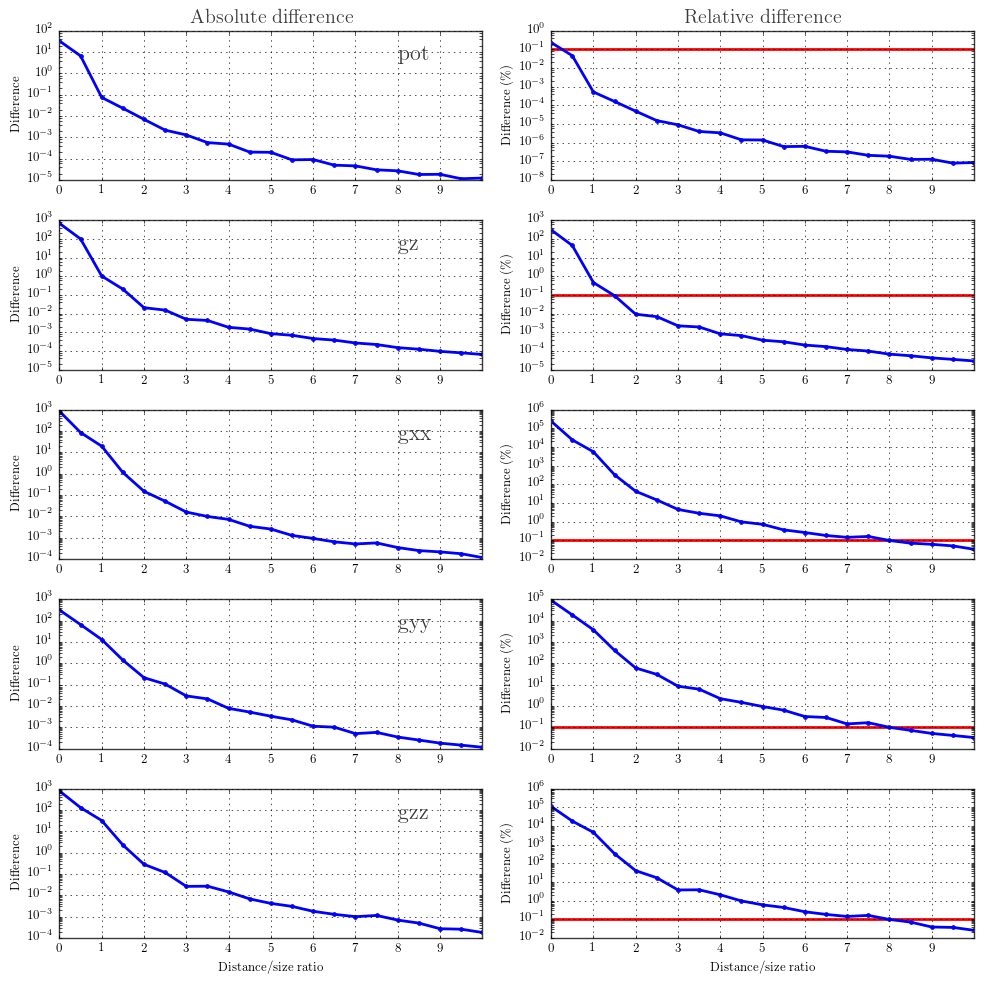

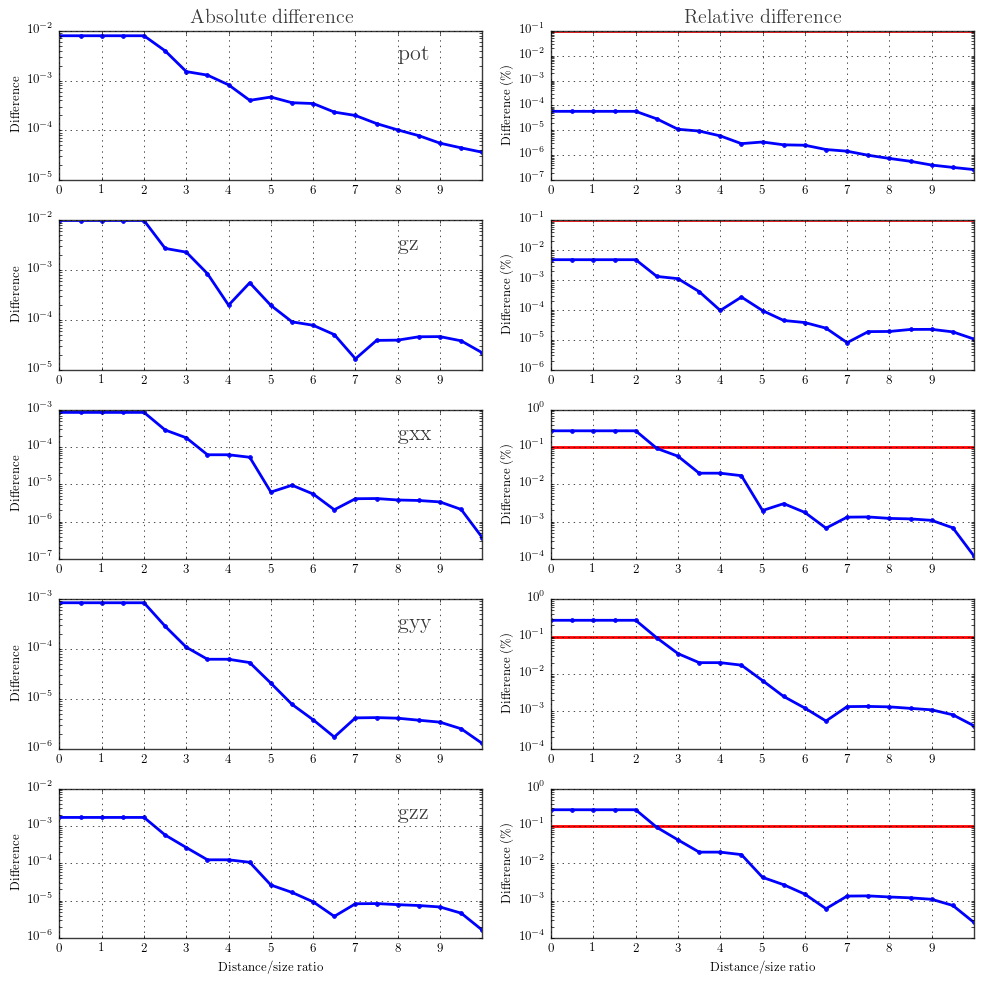

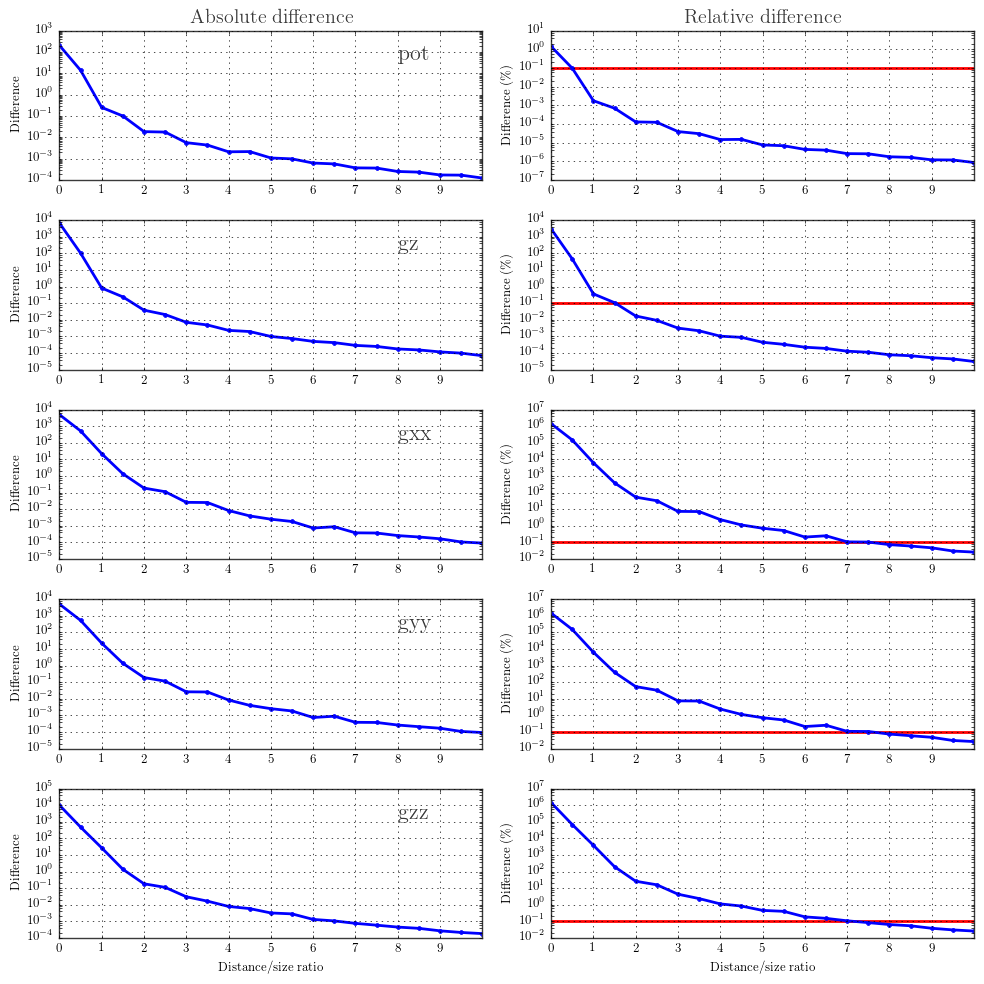

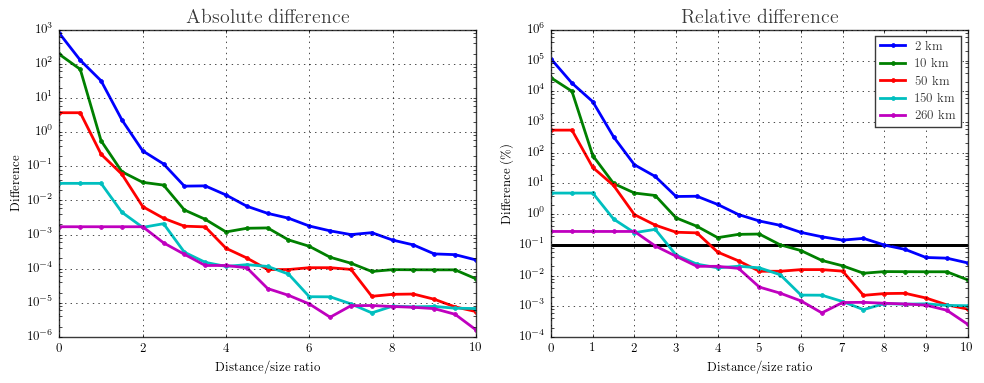

In [50]:
fig, subplots = plt.subplots(1, 2, figsize=(10, 4))
ax1, ax2 = subplots
for h in heights:
    d = max_diff_per_height.loc[h]
    ax1.plot(ratio, d, '.-')
    ax1.set_yscale('log')
    ax1.grid(True)
    ax1.set_ylabel('Difference')
    ref = calc_shell_effect(h, top, bottom, density)['gzz']
    ax2.plot(ratio, 100*d/np.abs(ref), '.-', label='{:.0f} km'.format(h*0.001))
    ax2.set_yscale('log')
    ax2.grid(True)
    ax2.set_ylabel('Difference (\%)')
    ax2.hlines(0.1, ratio.min(), ratio.max(), colors='k')
    ax2.set_xlim(ratio.min(), ratio.max())
ax2.legend(loc='upper right', numpoints=1)
ax2.set_xticks(range(11))
ax1.set_xlabel('Distance/size ratio')
ax2.set_xlabel('Distance/size ratio')
ax1.set_title('Absolute difference')
ax2.set_title('Relative difference')
plt.tight_layout()
plt.show()

## Check that the results for 2 km height are independent of size

Repeat the computations for a large sized tesseroid and make the difference x ratio curve.

In [51]:
big_size = 30

I'll need a new model file for this. 

In [52]:
big_model_file = make_model_file(big_size, top, bottom, density, verbose=True)

Model file: tesseroid_vs_spherical_shell_files/model-size30.0.tess
Model size: 72
Head:
0.0 30.0 -90.0 -60.0 1000.0 0.0 2670
30.0 60.0 -90.0 -60.0 1000.0 0.0 2670
60.0 90.0 -90.0 -60.0 1000.0 0.0 2670
90.0 120.0 -90.0 -60.0 1000.0 0.0 2670
120.0 150.0 -90.0 -60.0 1000.0 0.0 2670
150.0 180.0 -90.0 -60.0 1000.0 0.0 2670
180.0 210.0 -90.0 -60.0 1000.0 0.0 2670
210.0 240.0 -90.0 -60.0 1000.0 0.0 2670
240.0 270.0 -90.0 -60.0 1000.0 0.0 2670
270.0 300.0 -90.0 -60.0 1000.0 0.0 2670
Tail:
60.0 90.0 60.0 90.0 1000.0 0.0 2670
90.0 120.0 60.0 90.0 1000.0 0.0 2670
120.0 150.0 60.0 90.0 1000.0 0.0 2670
150.0 180.0 60.0 90.0 1000.0 0.0 2670
180.0 210.0 60.0 90.0 1000.0 0.0 2670
210.0 240.0 60.0 90.0 1000.0 0.0 2670
240.0 270.0 60.0 90.0 1000.0 0.0 2670
270.0 300.0 60.0 90.0 1000.0 0.0 2670
300.0 330.0 60.0 90.0 1000.0 0.0 2670
330.0 360.0 60.0 90.0 1000.0 0.0 2670


In [53]:
big_tess_files = []
for r in ratio:
    f = calc_tess_effect(big_model_file, height, big_size, r, where='pole')
    print('  {}'.format(f))
    big_tess_files.append(f)

  tesseroid_vs_spherical_shell_files/effect-model-size30.0.tess-ratio0.0-height2000-pole.txt
  tesseroid_vs_spherical_shell_files/effect-model-size30.0.tess-ratio0.5-height2000-pole.txt
  tesseroid_vs_spherical_shell_files/effect-model-size30.0.tess-ratio1.0-height2000-pole.txt
  tesseroid_vs_spherical_shell_files/effect-model-size30.0.tess-ratio1.5-height2000-pole.txt
  tesseroid_vs_spherical_shell_files/effect-model-size30.0.tess-ratio2.0-height2000-pole.txt
  tesseroid_vs_spherical_shell_files/effect-model-size30.0.tess-ratio2.5-height2000-pole.txt
  tesseroid_vs_spherical_shell_files/effect-model-size30.0.tess-ratio3.0-height2000-pole.txt
  tesseroid_vs_spherical_shell_files/effect-model-size30.0.tess-ratio3.5-height2000-pole.txt
  tesseroid_vs_spherical_shell_files/effect-model-size30.0.tess-ratio4.0-height2000-pole.txt
  tesseroid_vs_spherical_shell_files/effect-model-size30.0.tess-ratio4.5-height2000-pole.txt
  tesseroid_vs_spherical_shell_files/effect-model-size30.0.tess-ratio5

Again, load the data to a `DataFrame` and export to CSV.

In [54]:
big_data = load_tess_data(big_tess_files, ratio, big_size)

In [55]:
big_data.to_csv('../data/tesseroid-size-{:.0f}-height-{:.0f}-pole.csv'.format(big_size, height))

Do the same for the differences.

In [56]:
big_diff = calc_difference(big_data, shell_data)

In [57]:
big_diff.to_csv('../data/difference-size-{:.0f}-height-{:.0f}-pole.csv'.format(big_size, height))

Plot the error-ratio curves.

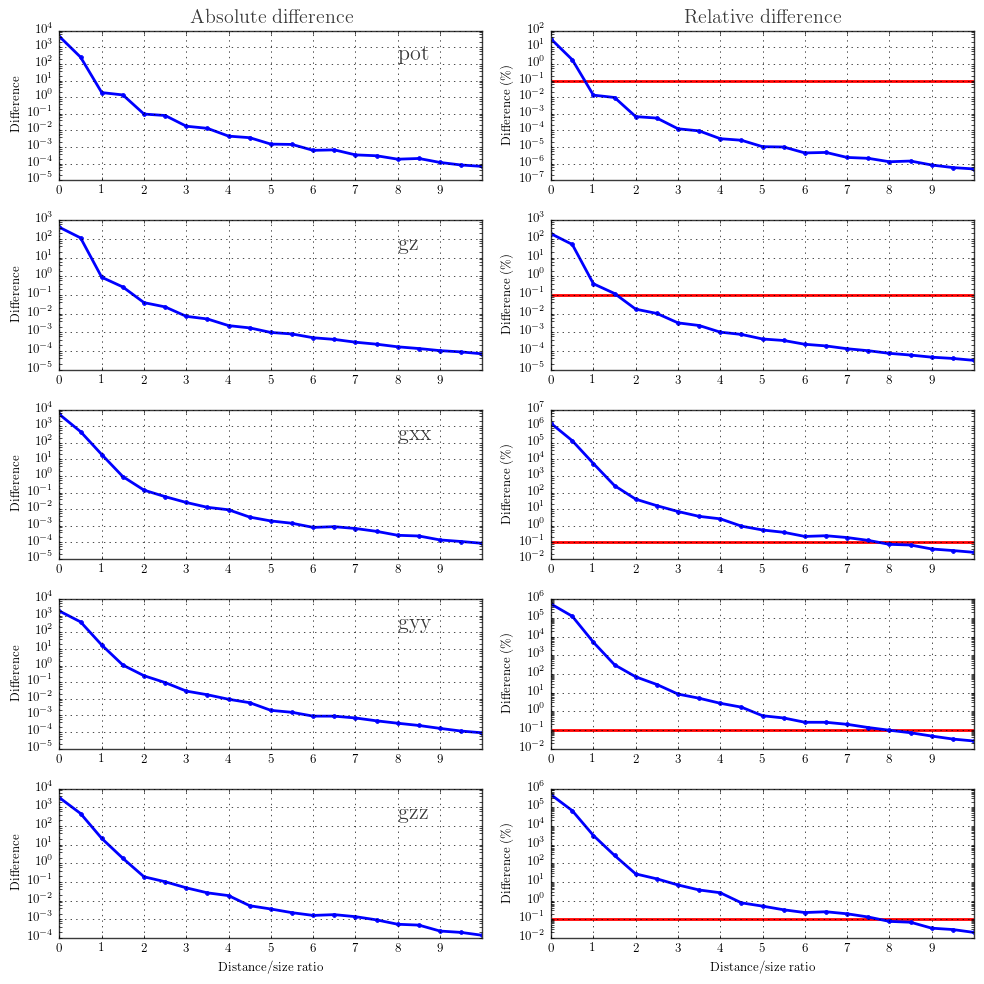

In [58]:
big_max_diff = big_diff.groupby(['size', 'ratio']).max()
plot_difference(big_max_diff, shell_data, size=big_size)

## Group the above into a single graph

Plot the relative differences for 2 km height at the pole, at the equator, at 260 km height, and for the 30º tesseroid.

In [59]:
def plot_all_relative(pole, equator, goce, big):    
    colors = "#8c510a #d8b365 #5ab4ac #01665e".split()
    fig, subplots = plt.subplots(2, 3, figsize=(9, 5), sharex='col', sharey='row')
    axes = subplots.ravel()[[0, 1, 3, 4, 5]]
    fields = ['pot', 'gz', 'gxx', 'gyy', 'gzz']
    titles = [r'$V$', r'$g_z$', r'$g_{xx}$', r'$g_{yy}$', r'$g_{zz}$']
    for i in xrange(5):
        ax, f, title = axes[i], fields[i], titles[i]    
        ax.text(0.9, 0.85, title, fontsize=14, 
                horizontalalignment='center', verticalalignment='center',
                bbox={'facecolor': 'w', 
                      'edgecolor': '#9b9b9b',
                      'linewidth': 0.5, 'pad': 8}, 
                transform=ax.transAxes)
        ax.plot(ratio, 100*pole[f]/np.abs(shell_data[f]), '.-', label='pole', color=colors[0])
        ax.plot(ratio, 100*equator[f]/np.abs(shell_data[f]), '.-', label='equator', color=colors[1])
        ax.plot(ratio, 100*big[f]/np.abs(shell_data[f]), '.-', label=r'$30^\circ$ size', color=colors[2])
        ax.plot(ratio, 100*goce[f]/np.abs(goce_height_shell_data[f]), '.-', label='260 km', color=colors[3])
        ax.hlines(0.1, ratio.min(), ratio.max(), colors='r')
        ax.set_xlim(ratio.min(), ratio.max())
        ax.set_yscale('log')
        ax.set_xticks(range(10))
        ax.grid(True)
    subplots[0, 0].legend(borderpad=1, numpoints=1, bbox_to_anchor=(2.7, 0.8), 
                          fancybox=True, shadow=True, fontsize=11)
    subplots[0, 2].axison = False
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.subplots_adjust(hspace=0, wspace=0)
    return fig

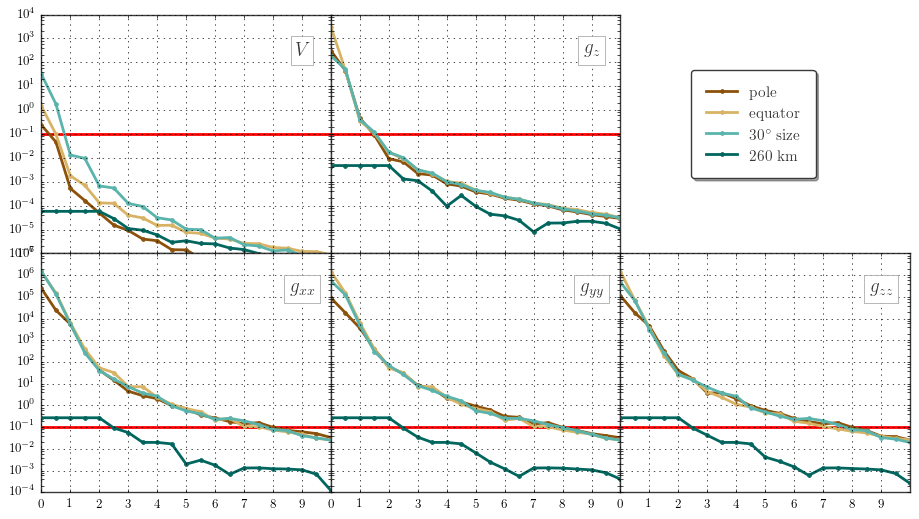

In [60]:
plot_all_relative(max_diff, eq_max_diff, goce_height_max_diff, big_max_diff)

## References
Grombein, T., K. Seitz, and B. Heck (2013), Optimized formulas for the gravitational field of a tesseroid, J Geod, 87(7), 645-660, doi:10.1007/s00190-013-0636-1.
